In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the data
data = pd.read_csv('/content/Symptom2Disease.csv')
data = data[['label', 'text']]
data.head()

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [2]:
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

# Text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

data['text_cleaned'] = data['text'].apply(clean_text)

# Split data
x_train, x_test, y_train, y_test = train_test_split(data['text_cleaned'], data['label_encoded'], test_size=0.2, random_state=42)



In [4]:
!pip install transformers datasets torch gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl 

In [3]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': x_train, 'label': y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': x_test, 'label': y_test}))

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [4]:
# Load the pre-trained tokenizer and model
from transformers import BertTokenizer, BertModel,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, return_tensors="pt")

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [6]:
# Load additional embeddings (e.g., GloVe)
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# Create combined embeddings
import torch

def get_combined_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    bert_embeddings = bert_model(**inputs).last_hidden_state.mean(dim=1)

    words = text.split()
    glove_embeddings = np.mean([word_vectors[word] if word in word_vectors else np.zeros(100) for word in words], axis=0)
    glove_embeddings = torch.tensor(glove_embeddings).float().unsqueeze(0)

    combined_embeddings = torch.cat((bert_embeddings, glove_embeddings), dim=1)
    return combined_embeddings

batch_texts = ["example text 1", "example text 2"]
batch_embeddings = torch.cat([get_combined_embeddings(text) for text in batch_texts], dim=0)
print(batch_embeddings.shape)


torch.Size([2, 868])


In [7]:
import torch
import torch.nn as nn
import numpy as np

class CombinedBERTModel(nn.Module):

    def __init__(self, bert_model, num_labels, tokenizer, word_vectors):
        super(CombinedBERTModel, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(768 + 100, num_labels)  # 768 from BERT and 100 from GloVe
        self.tokenizer = tokenizer
        self.word_vectors = word_vectors

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = outputs.last_hidden_state.mean(dim=1)

        glove_embeddings = []
        for i in range(input_ids.shape[0]):
            tokens = self.tokenizer.convert_ids_to_tokens(input_ids[i], skip_special_tokens=True)
            glove_emb = np.mean([self.word_vectors[word] if word in self.word_vectors else np.zeros(100) for word in tokens], axis=0)
            glove_embeddings.append(glove_emb)

        glove_embeddings = np.array(glove_embeddings)
        glove_embeddings = torch.tensor(glove_embeddings).float().to(bert_embeddings.device)
        combined_embeddings = torch.cat((bert_embeddings, glove_embeddings), dim=1)

        logits = self.fc(combined_embeddings)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.fc.out_features), labels.view(-1))

        return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}

num_labels = len(label_encoder.classes_)
model = CombinedBERTModel(bert_model=bert_model, num_labels=num_labels, tokenizer=tokenizer, word_vectors=word_vectors)


In [5]:
pip install transformers[torch]

In [21]:
# Training arguments
from transformers import TrainerCallback, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='/content/gdrive/My Drive/Colab Notebooks/',                # output directory
    num_train_epochs=5,                    # number of training epochs
    per_device_train_batch_size=8,         # batch size for training (reduced)
    per_device_eval_batch_size=8,          # batch size for evaluation (reduced)
    warmup_steps=500,                      # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                     # strength of weight decay
    logging_dir='./logs',                  # directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",           # evaluate every epoch
    save_strategy="epoch",                 # save every epoch to match evaluation strategy
    save_total_limit=3,                    # only last 3 models are saved
    load_best_model_at_end=True,           # load the best model at the end of training
    fp16=True,                             # enable mixed precision training
    gradient_accumulation_steps=2,         # accumulate gradients to simulate larger batch size
)

# Define metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted',zero_division=0)
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define the SaveModelCallback class
class SaveModelCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        epoch = int(state.epoch) + 1
        save_path = f'/content/gdrive/My Drive/Colab Notebooks/bert_model_epoch_{epoch}'
        torch.save(kwargs['model'].state_dict(), save_path)
        print(f'Model saved at epoch {epoch}')
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    callbacks=[SaveModelCallback],
)

In [9]:
import os

base_path = '/content/gdrive/My Drive/Colab Notebooks'
print(os.listdir(base_path))

['tpd2_1.ipynb', 'vijaytpd.ipynb', 'tpd-21.ipynb', 'gamma_corr_hist_equi_etc.ipynb', 'tpd_img.ipynb', 'eval1.ipynb', 'Abhicsd040.ipynb', 'linear.ipynb', 'linear_bad_example.ipynb', 'polynomial.ipynb', 'Decision_Tree.ipynb', 'Random_Forest.ipynb', 'intern_nlp.ipynb', 'INTERN.ipynb', 'model_epoch_6', 'bert_model_epoch_2', 'bert_model_epoch_3', 'bert_model_epoch_4', 'checkpoint-180', 'chkbert.ipynb', 'bert_model_epoch_5', 'checkpoint-240', '.ipynb_checkpoints', 'checkpoint-300', 'bert_model_epoch_6', 'intern_BERT.ipynb', 'model_saved1.pkl', 'intern_BERT2.ipynb']


In [10]:
checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/checkpoint-300'
trainer.train(resume_from_checkpoint=checkpoint_path)

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=300, training_loss=0.0, metrics={'train_runtime': 1.6956, 'train_samples_per_second': 2830.793, 'train_steps_per_second': 176.925, 'total_flos': 0.0, 'train_loss': 0.0, 'epoch': 5.0})

In [11]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.1290297657251358, 'eval_accuracy': 0.9708333333333333, 'eval_f1': 0.9705664628404903, 'eval_precision': 0.9731033549783549, 'eval_recall': 0.9708333333333333, 'eval_runtime': 575.8135, 'eval_samples_per_second': 0.417, 'eval_steps_per_second': 0.052, 'epoch': 5.0}


In [12]:
print("accuracy=",results['eval_accuracy']*100,"%")

accuracy= 97.08333333333333 %


In [17]:
def predict(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Forward pass through the model
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs['logits'], dim=1)

    # Assuming label_encoder is defined somewhere to convert predictions to labels
    predicted_label = label_encoder.inverse_transform(predictions.cpu().numpy())[0]

    return predicted_label

# Example usage
example_text = "high temperature  vomiting and  headache"
print(f"Predicted disease: {predict(example_text)}")

Predicted disease: Typhoid


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
eval_dataset=tokenized_datasets['test']

predictions = trainer.predict(eval_dataset)

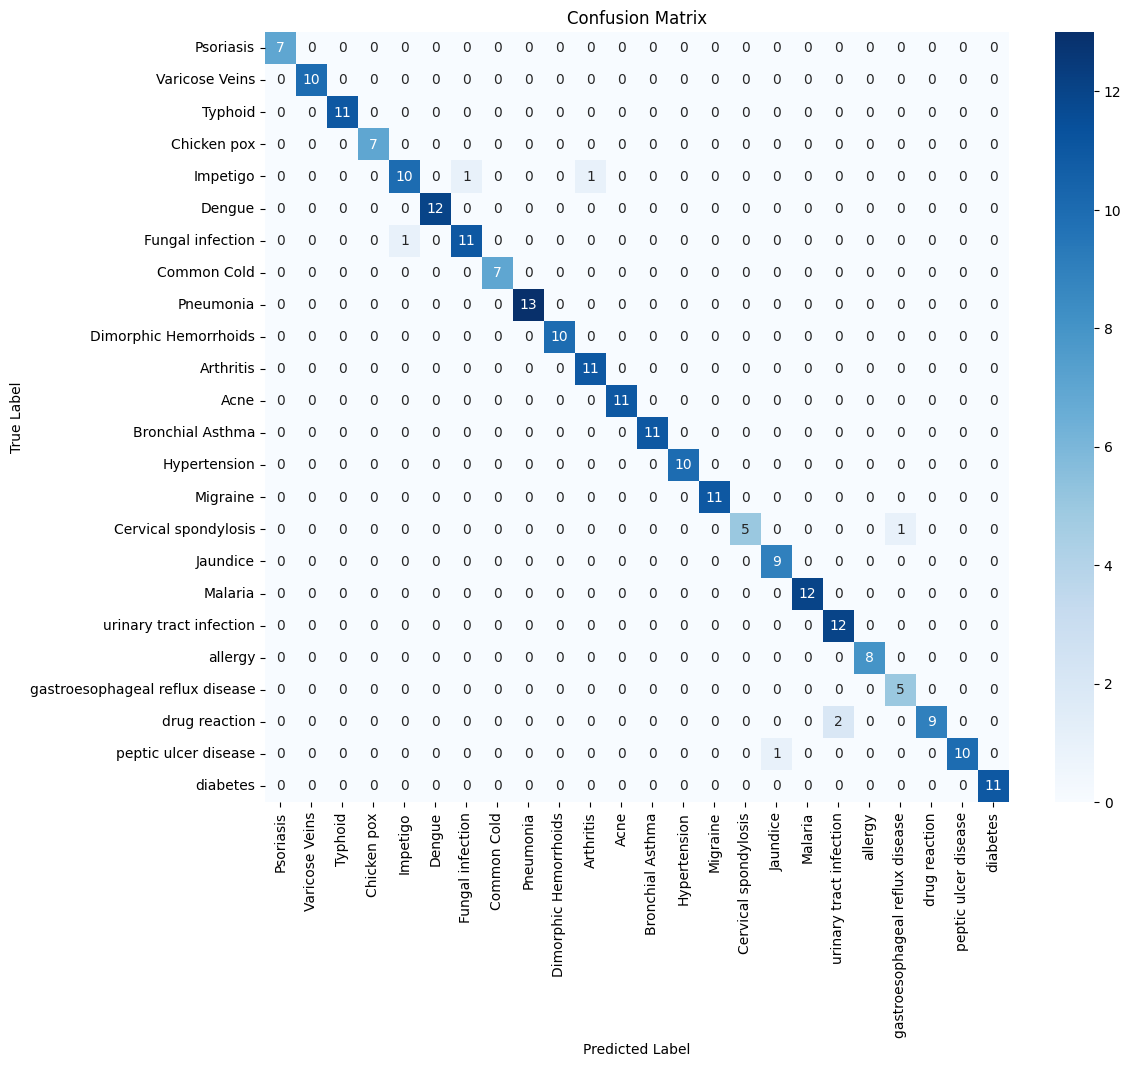

In [24]:
disease_names = data['label'].drop_duplicates().tolist()
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=disease_names, yticklabels=disease_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()